In [1]:
import pandas as pd
import numpy as np
from model.ActivationFunction import ActivationFunction
from model.Loss import *
from model.Layer import *
from sklearn.model_selection import train_test_split
from model.Classifier import Classifier
from model.Optimizer import *
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
df = pd.read_csv('data/train.csv')
X = df.drop('price_range', axis=1)
y = df['price_range']

# normalize the data
X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network from Scratch

In [30]:
# specify the layers and activation functions of the neural network
layers = [Layer(20, 128), 
          Layer(128, 128), 
        #   Layer(256, 128), 
          Layer(128, 4)]
activations = [ActivationFunction.ReLU(), 
               ActivationFunction.Sigmoid(), 
            #    ActivationFunction.Sigmoid(), 
               ActivationFunction.Softmax()]

# initialize the loss function
loss_func = Classifier.Softmax_CategoricalCrossentropy()

epochs = 10000

optimizer = Optimizer.SGD(decay=1e-3, momentum=0.9, learning_rate=0.01)

early_stopping = False
patience = 100
count = 0


lowest_loss = float('inf')

for epoch in range(epochs):
    layers[0].forward(X_train)
    activations[0].forward(layers[0].output)
    for i in range(1,len(layers)):
        layers[i].forward(activations[i-1].output)
        activations[i].forward(layers[i].output)

    loss = loss_func.forward(activations[-1].output, y_train)
    loss_func.losses.append(loss)

    predictions = np.argmax(activations[-1].output, axis=1)
    accuracy = np.mean(predictions == y_train)

    if not epoch % 1000:
        print(f'Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}')

    if loss < lowest_loss:
        lowest_loss = loss
        count = 0
    else:
        count += 1
        if count == patience:
            early_stopping = True
            break

    loss_func.backward(loss_func.output, y_train)
    layers[-1].backward(loss_func.dinputs)
    for i in range(len(layers) - 2, -1, -1):
        activations[i].backward(layers[i + 1].dinputs)
        layers[i].backward(activations[i].dinputs)

    if early_stopping:
        break

    optimizer.pre_update_params()
    for layer in layers:
        optimizer.update_params(layer)
    optimizer.post_update_params()


Epoch: 0, Loss: 1.3863646523765032, Accuracy: 0.255625
Epoch: 1000, Loss: 1.386003157807059, Accuracy: 0.255625
Epoch: 2000, Loss: 1.385814939665837, Accuracy: 0.255625
Epoch: 3000, Loss: 1.3841205908734742, Accuracy: 0.255625
Epoch: 4000, Loss: 1.2435683778351823, Accuracy: 0.856875


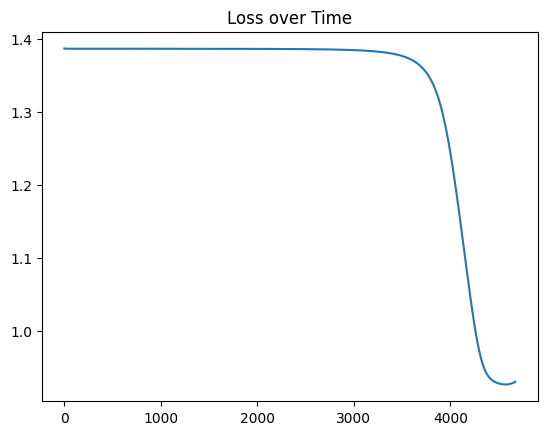

In [32]:
plt.plot(loss_func.losses)
plt.title('Loss over Time')
plt.show()

# Blackbox testing

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(hidden_layer_sizes=(128, 256, 128), max_iter=10000, 
                    activation='relu', solver='sgd', 
                    learning_rate_init=1, momentum=0.5, 
                    learning_rate='constant', alpha=1e-3,
                    random_state=420
                    )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.475


In [11]:
clf.out_activation_

'softmax'